-------------------------------------------------------------------
**TD DSA 2021 de Antoine Ly   -   rapport de Fabien Faivre**
-------------------------     -------------------------------------

# Modélisation

## Setup

In [23]:
!pip install textblob

In [24]:
!pip install emot

In [25]:
!pip install wordcloud

In [26]:
#Temps et fichiers
import os
import warnings
import time
from datetime import timedelta

#Manipulation de données
import pandas as pd
import numpy as np


# Text
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.util import ngrams

from textblob import TextBlob
import string
import re
import spacy 
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

#Modélisation
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


#Evaluation
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_score, recall_score


#Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

#Tracking d'expérience
import mlflow
import mlflow.sklearn



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
#Cellule strictement technique qui permet de sauver les exigences pour recréer au besoin l'image docker du projet
!pip freeze > /mnt/docker/requirements.txt

### Utilisation du package

Durent ce projet, certaines parties du code ont été re packagées dans un package propre au projet afin de factliter la lecture du core et permettre la réutilisabilité des développements

In [28]:
#Cette cellule permet d'appeler la version packagée du projet et d'en assurer le reload avant appel des fonctions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from dsa_sentiment.scripts.make_dataset import load_data
from dsa_sentiment.scripts.evaluate import eval_metrics
from dsa_sentiment.scripts.make_dataset import Preprocess_StrLower, Preprocess_transform_target

### Configuration de l'experiment MLFlow

[MLFlow](https://mlflow.org/) sera utilisé comme outil de suivi et de stockage des expérimentatiosn réalisées

In [30]:
mlflow.tracking.get_tracking_uri()

'/mnt/experiments'

### Chargement des données

In [50]:
# On Importe les données

#df
df_train=pd.read_parquet('/mnt/data/interim/df_train.gzip')
df_val=pd.read_parquet('/mnt/data/interim/df_val.gzip')
df_test=pd.read_parquet('/mnt/data/interim/df_test.gzip')

#X
X_train=pd.read_parquet('/mnt/data/interim/X_train.gzip')
X_val=pd.read_parquet('/mnt/data/interim/X_val.gzip')
X_test=pd.read_parquet('/mnt/data/interim/X_test.gzip')

X_train_prepro=pd.read_parquet('/mnt/data/interim/X_train_prepro.gzip')
X_val_prepro=pd.read_parquet('/mnt/data/interim/X_val_prepro.gzip')
X_test_prepro=pd.read_parquet('/mnt/data/interim/X_test_prepro.gzip')

#y
y_train=pd.read_parquet('/mnt/data/interim/y_train.gzip')
y_val=pd.read_parquet('/mnt/data/interim/y_val.gzip')
y_test=pd.read_parquet('/mnt/data/interim/y_test.gzip')

## Modélisation

### Création du code générique 

On commence par définir une fonction générique qui sera en capacité d'ajuster, optimiser et logger dans MLFlow les résultats de pipelines qui seront produits pour chaque essai

Le mode de fonctionnement souhaité consiste à 

1- définir un pipeline au sens de sklearn

2- utiliser une fonction générique pour ajuster le pipeline (éventuellement en optimisant les paramètres) et en stocker le résultat dans MLFlow

#### Préalables : création des fonctions de résultat souhaitées

La première étape consiste à construire une fonction générique qui calculera **les scores du pipeline que nous souhaitons suivre**.
Dans le cas présent comme l'exercice de classification est multiclasse, nous sommes intéressés par les `f1`, `precision` et `recall` calculés avec l'option `macro` qui réalise une moyenne des résultats obtenus par classe.

In [32]:
def score_estimator(
    estimator, X_train, X_test, df_train, df_test, target_col
):
    
    """
    Evalue un pipeline sur le jeu de train et test avec plusieurs métriques
    
    Ici les métriques utilisées sont :
    - f1 macro
    - precision macro
    - recall macro
    
    INPUTS :
        - estimator : un pipeline
        - X_train, X_test, df_train, df_test : les DataFrames contenant les jeux de données et test
        - target_col : le nom de la colonne cible dans les df
        
    OUTPUTS :
        - un DataFrame avec les métriques calculées sur les jeux de train et test fournis
    
    
    """

    metrics = [
        ("f1_macro", f1_score),   
        ("precision_macro", precision_score),
        ("recall_macro", recall_score),
        
    ]
    
    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y = df[target_col]
        y_pred = estimator.predict(X)
        for score_label, metric in metrics:
            score = metric(y, y_pred, average='macro')
            res.append(
                {"subset": subset_label, "metric": score_label, "score": score}
            )

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )
    return res

Pour pouvoir stocker les scores dans MLFlow, on les convertit en dictionnaires

In [33]:
def scores_to_dict(score_df):
    d = score_df['train'].to_dict()
    d1 = dict(zip([x+'_train_' for x in  list(d.keys())], list(d.values())))
    d = score_df['test'].to_dict()
    d2 = dict(zip([x+'_test' for x in  list(d.keys())], list(d.values())))
    d1.update(d2)
    return d1

Création d'une fonction affichant une matrice de confusion

In [34]:
def plot_cm(y_test, y_pred, target_names=[-1, 0, 1], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});

#### Création de la fonction d'entraînement générique

La fonction suivante est celle qui sera systématiquement appélée pour entraîner les pipelines

:::{tip}
L'évaluation fianle des modèles se faisant sur base de f1-macro dans le TD, c'est la métrique que nosu avons retenue pour la partie optimisation de la fonction générique
:::

In [43]:
def trainPipelineMlFlow(mlf_XP, 
                        xp_name_iter, 
                        pipeline, 
                        X_train, y_train, X_test, y_test, 
                        target_col='sentiment', 
                        fixed_params={}, 
                        use_opti=False, iterable_params={}, n_iter=20):
    """
    Fonction générique permettant d'entrainer et d'optimiser un pipeline sklearn
    Les paramètres et résultats sont stockés dans MLFlow
    
    INPUTS:
        - mlf_XP : nom de l'experiment à créer dans MLFlow
        - xp_name_iter : nom du run créé dans l'experiment de MLFlow
        - pipeline : un pipeline au sens ed sklearn
        - X_train, y_train, X_test, y_test : des dataframes contenant les jeux d'entrainement et de test
        - target_col : le nom de la colonne du DataFrame y qui constitue la cible
        - fixed_params : un dictionnaire contenant les paramètres fixes dont l'utilisateur souhaite fixer la valeur dans le pipeline
        - use_opti : boolean, est-ce qu'une optimisation est recherchée. Si oui, utilisera RandomizedSearchCV
        - iterable_params : un dictionnaire contenant les nom des paramètres ciblés du pipeline et des listes contenant les valeusr possibles
        - n_iter : le nombre d'itérations maximales à réaliser par RandomizedSearchCV
    
    FONCTIONNEMENT:
        stocke dans MLFlow :
        - le pipeline entrainé
        - les principaux paramètres correspondant aux paramètres fixes et aux éventuels paramètres optimaux après RandomizedSearchCV
        - les scores (scalaires) calculés par la fonction score_estimator
        - le temps d'exécution
        
        imprime :
        - le nom de l'experiment
        - le pipeline entraîné
        - les paramètres principaux (cf FONCTIONNEMENT)
        - la matrice de confusion du pipeline sur le jeu de test fourni en entrée
    
    OUTPUTS:
        - le pipeline entraîné
    
       
    """
  
    mlflow.set_experiment(mlf_XP)

    with mlflow.start_run(run_name=xp_name_iter):
        
        start_time = time.monotonic()  
        
        warnings.filterwarnings("ignore")
        
        # fit pipeline
        pipeline.set_params(**fixed_params)
        if not use_opti:
            search = pipeline
        else:
            search = RandomizedSearchCV(estimator = pipeline, 
                                        param_distributions = iterable_params, 
                                        n_jobs = -1, 
                                        cv = 5, 
                                        scoring = 'f1_macro', 
                                        n_iter = n_iter)
        
        search.fit(X_train, y_train[target_col])
                
        # get params
        params_to_log = fixed_params #select initial params
        if use_opti:
            params_to_log.update(search.best_params_) #update for optimal solution
        mlflow.log_params(params_to_log)
        
        # Evaluate metrics
        y_pred=search.predict(X_test)
        score = score_estimator(estimator=search, 
                                         X_train=X_train, 
                                         X_test=X_test, 
                                         df_train=y_train, 
                                         df_test=y_test, 
                                         target_col=target_col
                                )
        
        # Print out metrics
        print('XP :', xp_name_iter, '\n')
        print('pipeline : \n', search, '\n')
        print("params: \n", params_to_log, '\n')
        print('scores : \n', score, '\n')
        print("Test confusion matrix: \n")
        plot_cm(y_test, search.predict(X_test))
        
        
        #r Report to MlFlow
        mlflow.log_metrics(scores_to_dict(score))
        mlflow.sklearn.log_model(pipeline, xp_name_iter)
        
        end_time = time.monotonic()
        elapsed_time = timedelta(seconds=end_time - start_time)
        print('elapsed time :', elapsed_time)
        mlflow.set_tag(key="elapsed_time", value=elapsed_time)   
        
        
        
    return search;
        

#### Utilitaires : pour faciliter l'utilisation des pipelines

Si les pipelines permettent un traitement souple et homogène entre les jeux de données, leur manipulation n'est pas évidente.
Notamment, le libellé des paramètres peut vide devenir délicat et difficilement lisible avec une combinaison de nom d'étape et du nom du paramètre dans l'étape du pipeline.
La fonction suivante permet de rechercher tous les paramètres d'un pipeline qui contiennent une chaine de caractère spécifique.

In [36]:
def target_params(pipe, dict_keyval):
    """
    Crée un dictionnaire constitué de tous les paramètres incluant 'pattern' d'un pipe et leur assigne une valeur unique
    """
    
    res={}
    for key in list(dict_keyval.keys()):
    
        target = "[a-zA-Z\_]+__" + key

        rs = re.findall(target, ' '.join(list(pipe.get_params().keys())))
        rs=dict.fromkeys(rs, dict_keyval[key])
        res.update(rs)
    return res

#### Utilitaires : Adaptation des pipelines

La cellule suivante permet de créer des étapes de sélection de colonnes dans les Data Frame en entrée

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.field]]

### Approche initiale

On commence par construire un modèle simple qui nous servira de modèle de base que nous chercherons à améliorer.

:::{warning}

Dans cette première étape, nous travaillerons sur le jeu `train` que nous avon découpé et évaluerons ses performances sur le jeu `val`.

Seuls les principaux modèles seront réentrainés sur `{ train + val }` avant d'être évalués sur le véritable jeu `test`

:::

#### Bag of Words avec Random Forest

Dans cette expérimentation, nous créons un modèle simple :

![BoW_RF](images/Pipeline_BoW_RF.png)

In [38]:
bow_pipeline = Pipeline(
    steps=[
        ('coltext', TextSelector('text')), #Sélection de la colonne à transformer (corpus)
        ("tfidf", TfidfVectorizer()),
        ("classifier", RandomForestClassifier(n_jobs=-1)),
    ]
)


Déjà dans cet exemple simple, le nombre de paramètres est important et leur nom vite complexe :

In [39]:
list(bow_pipeline.get_params().keys())

['memory',
 'steps',
 'verbose',
 'coltext',
 'tfidf',
 'classifier',
 'coltext__field',
 'tfidf__analyzer',
 'tfidf__binary',
 'tfidf__decode_error',
 'tfidf__dtype',
 'tfidf__encoding',
 'tfidf__input',
 'tfidf__lowercase',
 'tfidf__max_df',
 'tfidf__max_features',
 'tfidf__min_df',
 'tfidf__ngram_range',
 'tfidf__norm',
 'tfidf__preprocessor',
 'tfidf__smooth_idf',
 'tfidf__stop_words',
 'tfidf__strip_accents',
 'tfidf__sublinear_tf',
 'tfidf__token_pattern',
 'tfidf__tokenizer',
 'tfidf__use_idf',
 'tfidf__vocabulary',
 'classifier__bootstrap',
 'classifier__ccp_alpha',
 'classifier__class_weight',
 'classifier__criterion',
 'classifier__max_depth',
 'classifier__max_features',
 'classifier__max_leaf_nodes',
 'classifier__max_samples',
 'classifier__min_impurity_decrease',
 'classifier__min_impurity_split',
 'classifier__min_samples_leaf',
 'classifier__min_samples_split',
 'classifier__min_weight_fraction_leaf',
 'classifier__n_estimators',
 'classifier__n_jobs',
 'classifier__oob

En première intention on ajuste le pipeline sur le jeu d'entraînement avant les étapes de preprocessing réalisées lors de l'EDA

XP : base_TfIdf_RF 

pipeline : 
 Pipeline(steps=[('coltext', TextSelector(field='text')),
                ('tfidf', TfidfVectorizer()),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))]) 

params: 
 {'classifier__random_state': 42} 

scores : 
 subset            train    test
metric                         
f1_macro         0.9991  0.6754
precision_macro  0.9990  0.7028
recall_macro     0.9991  0.6651 

Test confusion matrix: 

elapsed time : 0:00:03.443924


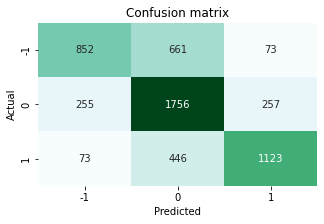

In [45]:
base_TfIdf_RF_= trainPipelineMlFlow(
                    mlf_XP = "Rapport",
                    xp_name_iter = "base_TfIdf_RF", 
                    pipeline = bow_pipeline, 
                    X_train = X_train, y_train = y_train, X_test = X_val, y_test = y_val,
                    target_col = 'sentiment',
                    fixed_params = {'classifier__random_state':42}
                    );

Le modèle de base produit un f1 macro de 67,5% sur le jeu de validation avec le paramétrage par défaut de sklearn.
On observe le très fort f1 macro sur le jeu d'entraînement qui indique un fort surapprentissage.
L'intérêt de ce pipeline est d'être très rapide à l'entraînement (à peine plus de 3 secondes ici)

#### variante preprocessing

In [48]:
X_train_prepro

,text
0,responded going
1,soo sad miss san diego!!
2,boss bullying
3,interview! leave alone
4,sons ** put releases already bought
...,...
21979,allowed calculator exam despite containin...
21980,haha miine
21981,sorry people rude isaac get manners ...
21982,enjoy fancy meals smtimes thr joy solit...


In [51]:
X_val_prepro

,text
0,_jessicab_** yip aw gonna miss bb
1,_violence heyy babyy
2,6am sunday going meet mom breakfast be...
3,today show still gotten touch wish wo...
4,checked email got follower withb name li...
...,...
5491,wish could come see denver husband lost jo...
5492,wondered rake client made clear net ...
5493,yay good enjoy break probably need he...
5494,worth **


XP : base_TfIdf_RF_prepro 

pipeline : 
 Pipeline(steps=[('coltext', TextSelector(field='text')),
                ('tfidf', TfidfVectorizer()),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))]) 

params: 
 {'classifier__random_state': 42} 

scores : 
 subset            train    test
metric                         
f1_macro         0.9974  0.7047
precision_macro  0.9975  0.7163
recall_macro     0.9973  0.6999 

Test confusion matrix: 

elapsed time : 0:00:03.569189


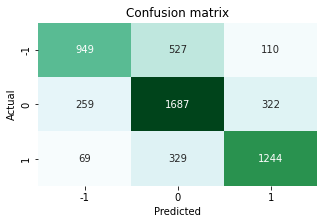

In [52]:
base_TfIdf_RF_prepro_= trainPipelineMlFlow(
                            mlf_XP = "Rapport",
                            xp_name_iter = "base_TfIdf_RF_prepro", 
                            pipeline = bow_pipeline, 
                            X_train = X_train_prepro, y_train = y_train, X_test = X_val_prepro, y_test = y_val,
                            target_col = 'sentiment',
                            fixed_params = {'classifier__random_state':42}
                        );

:::{admonition} apport du preprocessing
On observe tout de suite l'apport des retraitemenst effectués à l'étape EDA : le modèle est passé à une performance de **70,47%** sur le jeu de validation sans autres modifications
:::

#### variante optimisée

Une variante consiste à essayer d'ajuster lees hyper paramètres du pipeline dans l'espoire de gagner en performance

XP : Bag Of Words - RF-Opti - n_iter_30 

pipeline : 
 RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('coltext',
                                              TextSelector(field='text')),
                                             ('tfidf', TfidfVectorizer()),
                                             ('classifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__class_weight': ['balanced',
                                                                     None],
                                        'classifier__max_depth': [5, 8, 15, 25,
                                                                  30],
                                        'classifier__m

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('coltext',
                                              TextSelector(field='text')),
                                             ('tfidf', TfidfVectorizer()),
                                             ('classifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__class_weight': ['balanced',
                                                                     None],
                                        'classifier__max_depth': [5, 8, 15, 25,
                                                                  30],
                                        'classifier__min_samples_leaf': [1, 2,
                              

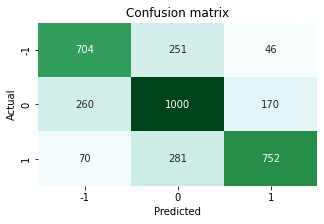

In [41]:
params = {
    "tfidf__use_idf": [True, False],
    "tfidf__ngram_range": [(1, 1), (1, 2), (1,3)],
    "classifier__bootstrap": [True, False],
    "classifier__class_weight": ["balanced", None],
    "classifier__n_estimators": [100, 300, 500, 800, 1200],
    "classifier__max_depth": [5, 8, 15, 25, 30],
    "classifier__min_samples_split": [2, 5, 10, 15, 100],
    "classifier__min_samples_leaf": [1, 2, 5, 10]
}

trainPipelineMlFlow(
                    mlf_XP="DSA_Tweets",
                    xp_name_iter="Bag Of Words - RF-Opti - n_iter_30", 
                    pipeline=bow_pipeline, 
                    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    target_col='sentiment',
                    fixed_params={'classifier__random_state':42},
                    use_opti=True,
                    iterable_params=params,
                    n_iter=30
                    )

### Bag of Words avec régression logistique

In [45]:
bow_pipeline_LR = Pipeline(
    steps=[
        ('coltext', TextSelector('text')), #Sélection de la colonne à transformer (corpus)
        ("tfidf", TfidfVectorizer()),
        ("classifier", LogisticRegression(solver='liblinear', multi_class='auto')),
    ]
)

In [120]:
list(bow_pipeline_LR.get_params().keys())

['memory',
 'steps',
 'verbose',
 'coltext',
 'tfidf',
 'classifier',
 'coltext__field',
 'tfidf__analyzer',
 'tfidf__binary',
 'tfidf__decode_error',
 'tfidf__dtype',
 'tfidf__encoding',
 'tfidf__input',
 'tfidf__lowercase',
 'tfidf__max_df',
 'tfidf__max_features',
 'tfidf__min_df',
 'tfidf__ngram_range',
 'tfidf__norm',
 'tfidf__preprocessor',
 'tfidf__smooth_idf',
 'tfidf__stop_words',
 'tfidf__strip_accents',
 'tfidf__sublinear_tf',
 'tfidf__token_pattern',
 'tfidf__tokenizer',
 'tfidf__use_idf',
 'tfidf__vocabulary',
 'classifier__C',
 'classifier__class_weight',
 'classifier__dual',
 'classifier__fit_intercept',
 'classifier__intercept_scaling',
 'classifier__l1_ratio',
 'classifier__max_iter',
 'classifier__multi_class',
 'classifier__n_jobs',
 'classifier__penalty',
 'classifier__random_state',
 'classifier__solver',
 'classifier__tol',
 'classifier__verbose',
 'classifier__warm_start']

Bag Of Words - LR-Opti - n_iter_30
params:
subset            train    test
metric                         
f1_macro         0.7833  0.7102
precision_macro  0.8000  0.7254
recall_macro     0.7746  0.7020
elapsed time : 0:00:07.454859


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('coltext',
                                              TextSelector(field='text')),
                                             ('tfidf', TfidfVectorizer()),
                                             ('classifier',
                                              LogisticRegression(n_jobs=-1,
                                                                 random_state=42,
                                                                 solver='liblinear'))]),
                   n_iter=30, n_jobs=-2,
                   param_distributions={'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3)],
                                        'tfidf__use_idf': [True, False]},
                   scoring='f1_macro')

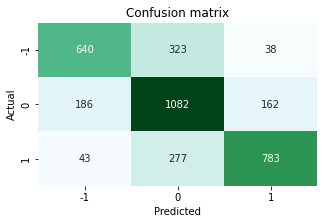

In [54]:
params = {
    "tfidf__use_idf": [True, False],
    "tfidf__ngram_range": [(1, 1), (1, 2), (1,3)]
}    

trainPipelineMlFlow(
                    mlf_XP="DSA_Tweets",
                    xp_name_iter="Bag Of Words - LR-Opti - n_iter_30", 
                    pipeline=bow_pipeline_LR, 
                    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    target_col='sentiment',
                    fixed_params={'classifier__random_state':42},
                    use_opti=True,
                    iterable_params=params,
                    n_iter=30
                    )

XP : Bag Of Words - LR-Opti - n_iter_30 

pipeline : 
 subset            train    test
metric                         
f1_macro         0.7833  0.7102
precision_macro  0.8000  0.7254
recall_macro     0.7746  0.7020 

params: 
 

Confusion matrix: 

elapsed time : 0:00:15.012709


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('coltext',
                                              TextSelector(field='text')),
                                             ('tfidf', TfidfVectorizer()),
                                             ('classifier',
                                              LogisticRegression(n_jobs=-1,
                                                                 random_state=42,
                                                                 solver='liblinear'))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3), (1, 4)],
                                        'tfidf__use_idf': [True, False]},
                   scoring='f1_macro')

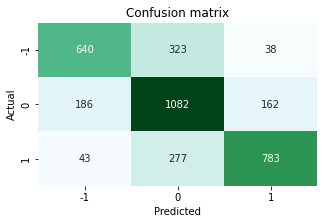

In [69]:
pipe = bow_pipeline_LR


params = target_params(pipe, {
    "use_idf": [True, False],
    "ngram_range": [(1, 1), (1, 2), (1,3), (1,4)]
})



trainPipelineMlFlow(
                    mlf_XP="DSA_Tweets",
                    xp_name_iter="Bag Of Words - LR-Opti - n_iter_30", 
                    pipeline = pipe, 
                    X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs':-1,'random_state':42}),
                    use_opti = True,
                    iterable_params = params,
                    n_iter = 30
                    )

In [68]:
pipe = bow_pipeline_LR_prepro


params = target_params(pipe, {
    "use_idf": [True, False],
    "ngram_range": [(1, 1), (1, 2), (1,3), (1,4)]
})



trainPipelineMlFlow(
                    mlf_XP="DSA_Tweets",
                    xp_name_iter="Bag Of Words - LR-Opti - n_iter_30", 
                    pipeline = pipe, 
                    X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs':-1,'random_state':42}),
                    use_opti = True,
                    iterable_params = params,
                    n_iter = 30
                    )

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [123]:
trainPipelineMlFlow(
                    mlf_XP="DSA_Tweets",
                    xp_name_iter="Bag Of Words - LR", 
                    pipeline=bow_pipeline_LR, 
                    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                    target_col='sentiment',
                    fixed_params={'classifier__random_state':42}
                    )

Bag Of Words - LR
params:
subset            train    test
metric                         
f1_macro         0.7849  0.6956
precision_macro  0.8034  0.7147
recall_macro     0.7757  0.6864
elapsed time : 0:00:00.673433


Pipeline(steps=[('coltext', TextSelector(field='text')),
                ('tfidf', TfidfVectorizer()),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

## TextPreprocessor

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, 
                 apply_lemmatizer=True,
                 apply_lowercase=True,
                 apply_url_standerdisation=True,
                 apply_user_standerdisation=True,
                 apply_emoticon_to_words=True,
                 apply_stopwords_removal=True,
                 apply_shortwords_removal=True,
                 apply_non_alphabetical_removal=True,
                 apply_only_2_consecutive_charac=True):
        
        self.apply_lemmatizer = apply_lemmatizer
        self.apply_lowercase = apply_lowercase
        self.apply_url_standerdisation = apply_url_standerdisation
        self.apply_user_standerdisation = apply_user_standerdisation
        self.apply_emoticon_to_words = apply_emoticon_to_words
        self.apply_stopwords_removal = apply_stopwords_removal
        self.apply_shortwords_removal = apply_shortwords_removal
        self.apply_non_alphabetical_removal = apply_non_alphabetical_removal
        self.apply_only_2_consecutive_charac = apply_only_2_consecutive_charac
        
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        res= preprocess_text(X, 
                               apply_lemmatizer = self.apply_lemmatizer,
                               apply_lowercase = self.apply_lowercase,
                               apply_url_standerdisation = self.apply_url_standerdisation,
                               apply_user_standerdisation = self.apply_user_standerdisation,
                               apply_emoticon_to_words = self.apply_emoticon_to_words,
                               apply_stopwords_removal = self.apply_stopwords_removal,
                               apply_shortwords_removal = self.apply_shortwords_removal,
                               apply_non_alphabetical_removal = self .apply_non_alphabetical_removal,
                               apply_only_2_consecutive_charac = self.apply_only_2_consecutive_charac
                              )
        return res



In [79]:
bow_pipeline_LR_prepro = Pipeline(
    steps=[
        ('coltext', TextSelector('text')), #Sélection de la colonne à transformer (corpus)
        ('prepro', TextPreprocessor()), 
        ("tfidf", TfidfVectorizer()),
        ("classifier", LogisticRegression(solver='liblinear', multi_class='auto')),
    ]
)

In [80]:
list(bow_pipeline_LR_prepro.get_params().keys())

['memory',
 'steps',
 'verbose',
 'coltext',
 'prepro',
 'tfidf',
 'classifier',
 'coltext__field',
 'prepro__apply_emoticon_to_words',
 'prepro__apply_lemmatizer',
 'prepro__apply_lowercase',
 'prepro__apply_non_alphabetical_removal',
 'prepro__apply_only_2_consecutive_charac',
 'prepro__apply_shortwords_removal',
 'prepro__apply_stopwords_removal',
 'prepro__apply_url_standerdisation',
 'prepro__apply_user_standerdisation',
 'tfidf__analyzer',
 'tfidf__binary',
 'tfidf__decode_error',
 'tfidf__dtype',
 'tfidf__encoding',
 'tfidf__input',
 'tfidf__lowercase',
 'tfidf__max_df',
 'tfidf__max_features',
 'tfidf__min_df',
 'tfidf__ngram_range',
 'tfidf__norm',
 'tfidf__preprocessor',
 'tfidf__smooth_idf',
 'tfidf__stop_words',
 'tfidf__strip_accents',
 'tfidf__sublinear_tf',
 'tfidf__token_pattern',
 'tfidf__tokenizer',
 'tfidf__use_idf',
 'tfidf__vocabulary',
 'classifier__C',
 'classifier__class_weight',
 'classifier__dual',
 'classifier__fit_intercept',
 'classifier__intercept_scaling'

XP : Bag Of Words - LRprepro 

pipeline : 
 subset            train    test
metric                         
f1_macro         0.7823  0.7030
precision_macro  0.7998  0.7192
recall_macro     0.7735  0.6945 

params: 
 

Confusion matrix: 

elapsed time : 0:02:15.036337


Pipeline(steps=[('coltext', TextSelector(field='text')),
                ('prepro', TextPreprocessor()), ('tfidf', TfidfVectorizer()),
                ('classifier',
                 LogisticRegression(n_jobs=-1, random_state=42,
                                    solver='liblinear'))])

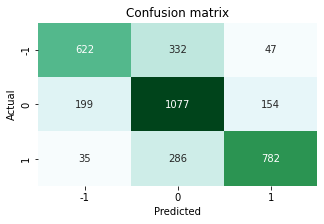

In [81]:
trainPipelineMlFlow(
                    mlf_XP = "DSA_Tweets",
                    xp_name_iter = "Bag Of Words - LRprepro", 
                    pipeline = bow_pipeline_LR_prepro, 
                    X_train = X_train , y_train = y_train , X_test = X_test , y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs': -1, 'random_state':42})
                    )

In [35]:
target_params(bow_pipeline_LR_prepro, {'n_jobs': -1, 'random_state':42})

{'classifier__n_jobs': -1, 'classifier__random_state': 42}

XP : Bag Of Words - LRprepro 

pipeline : 
 subset            train    test
metric                         
f1_macro         0.7817  0.7029
precision_macro  0.7993  0.7196
recall_macro     0.7729  0.6943 

params: 
 

Confusion matrix: 

elapsed time : 0:01:01.560316


Pipeline(steps=[('coltext', TextSelector(field='text')),
                ('prepro', TextPreprocessor(apply_emoticon_to_words=False)),
                ('tfidf', TfidfVectorizer()),
                ('classifier',
                 LogisticRegression(n_jobs=-1, random_state=42,
                                    solver='liblinear'))])

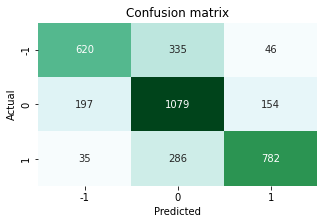

In [82]:
pipe = bow_pipeline_LR_prepro

trainPipelineMlFlow(
                    mlf_XP = "DSA_Tweets",
                    xp_name_iter = "Bag Of Words - LRprepro", 
                    pipeline = pipe, 
                    X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs': -1, 'random_state':42, 'apply_emoticon_to_words':False})
                    )

### Ici

params = target_params(pipe, {'apply_emoticon_to_words': [True, False]
                              ,
                              'apply_lemmatizer': [True, False],
                              'apply_lowercase': [True, False],
                              'apply_non_alphabetical_removal': [True, False],
                              'apply_shortwords_removal': [True, False],
                              'apply_stopwords_removal': [True, False],
                              'apply_url_standerdisation': [True, False],
                              'apply_user_standerdisation': [True, False]
                              })


In [85]:
pipe = bow_pipeline_LR


params = target_params(pipe, 
                       {"use_idf": [True, False]}
                      )


pipe = bow_pipeline_LR_prepro

trainPipelineMlFlow(
                    mlf_XP = "DSA_Tweets",
                    xp_name_iter = "Bag Of Words - LRprepro - Opti", 
                    pipeline = pipe, 
                    X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs': -1, 'random_state':42}),
                    use_opti = True,
                    iterable_params = params
                    )

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [164]:
pipe = bow_pipeline_LR_prepro

params = target_params(pipe, {'apply_emoticon_to_words': [True, False],
                              'apply_lemmatizer': [True, False],
                              'apply_lowercase': [True, False],
                              'apply_non_alphabetical_removal': [True, False],
                              'apply_shortwords_removal': [True, False],
                              'apply_stopwords_removal': [True, False],
                              'apply_url_standerdisation': [True, False],
                              'apply_user_standerdisation': [True, False]
                              })

params


{'prepro__apply_emoticon_to_words': [True, False],
 'prepro__apply_lemmatizer': [True, False],
 'prepro__apply_lowercase': [True, False],
 'prepro__apply_non_alphabetical_removal': [True, False],
 'prepro__apply_shortwords_removal': [True, False],
 'prepro__apply_stopwords_removal': [True, False],
 'prepro__apply_url_standerdisation': [True, False],
 'prepro__apply_user_standerdisation': [True, False]}

In [89]:
pipe = bow_pipeline_LR_prepro


params = target_params(pipe, {
    "use_idf": [True, False]
})



trainPipelineMlFlow(
                    mlf_XP="DSA_Tweets",
                    xp_name_iter="Bag Of Words - LR-Opti - n_iter_30", 
                    pipeline = pipe, 
                    X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs':-1,'random_state':42}),
                    use_opti = True,
                    iterable_params = params,
                    n_iter = 30
                    )

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [102]:
X_train_prepro = pd.DataFrame(preprocess_text(X_train['text']), columns=['text'])

In [103]:
X_train_prepro

,text
0,responded going
1,soo sad miss san diego!!
2,bos bullying
3,interview! leave alone
4,son ** put release already bought
...,...
27475,wish could come see denver husband lost jo...
27476,wondered rake client made clear net ...
27477,yay good enjoy break probably need he...
27478,worth **


In [104]:
X_test_prepro = pd.DataFrame(preprocess_text(X_test['text']), columns=['text'])

In [105]:
X_test

,text
0,Last session of the day http://twitpic.com/67ezh
1,Shanghai is also really exciting (precisely -...
2,"Recession hit Veronique Branquinho, she has to..."
3,happy bday!
4,http://twitpic.com/4w75p - I like it!!
...,...
3529,"its at 3 am, im very tired but i can`t sleep ..."
3530,All alone in this old house again. Thanks for...
3531,I know what you mean. My little dog is sinkin...
3532,_sutra what is your next youtube video gonna b...


XP : Bag Of Words - LR-prepro 

pipeline : 
 subset            train    test
metric                         
f1_macro         0.7554  0.7031
precision_macro  0.7730  0.7201
recall_macro     0.7470  0.6943 

params: 
 

Confusion matrix: 

elapsed time : 0:00:02.456034


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('coltext',
                                              TextSelector(field='text')),
                                             ('tfidf', TfidfVectorizer()),
                                             ('classifier',
                                              LogisticRegression(n_jobs=-1,
                                                                 random_state=42,
                                                                 solver='liblinear'))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'tfidf__use_idf': [True, False]},
                   scoring='f1_macro')

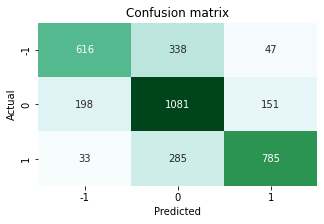

In [106]:
pipe = bow_pipeline_LR


params = target_params(pipe, {
    "use_idf": [True, False]
})



trainPipelineMlFlow(
                    mlf_XP="DSA_Tweets",
                    xp_name_iter="Bag Of Words - LR-prepro", 
                    pipeline = pipe, 
                    X_train = X_train_prepro, y_train = y_train, X_test = X_test_prepro, y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs':-1,'random_state':42}),
                    use_opti = True,
                    iterable_params = params,
                    n_iter = 30
                    )

# PyTorch

In [29]:
import torch
torch.cuda.is_available()

True

In [30]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import pipeline


import numpy as np
from scipy.special import softmax
import csv
import urllib.request


In [31]:

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


In [32]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

model = AutoModelForSequenceClassification.from_pretrained('/mnt/pretrained_models/'+MODEL)
tokenizer = AutoTokenizer.from_pretrained('/mnt/pretrained_models/'+MODEL)
config = AutoConfig.from_pretrained('/mnt/pretrained_models/'+MODEL)

In [33]:
# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [34]:
nlp=pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0, return_all_scores=True)

In [35]:
def TorchTwitterRoBERTa_Pred(text = "Good night 😊"):
    text = preprocess(text)
    otpt = nlp(text)[0]
#    otpt = (list(otpt[i].values())[1] for i in range(len(otpt)))
    neg = otpt[0]['score']
    neu = otpt[1]['score']
    pos = otpt[2]['score']
    
#    NewName = {0:'roBERTa-neg', 1:'roBERTa-neu', 2:'roBERTa-pos'}
#    otpt = pd.json_normalize(otpt).transpose().rename(columns=NewName).reset_index().drop([0]).drop(columns=['index'])
    return neg, neu, pos

In [36]:
test = TorchTwitterRoBERTa_Pred()
test

(0.007609867490828037, 0.1458120346069336, 0.8465781211853027)

In [37]:
def run_loopy_roBERTa(df):
    v_neg, v_neu, v_pos = [], [], []
    for _, row in df.iterrows():
        v1, v2, v3 = TorchTwitterRoBERTa_Pred(row.values[0])
        v_neg.append(v1)
        v_neu.append(v2)
        v_pos.append(v3)
    df_result = pd.DataFrame({'roBERTa_neg': v_neg,
                              'roBERTa_neu': v_neu,
                              'roBERTa_pos': v_pos})
    return df_result

In [38]:
class clTwitterroBERTa(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        res = run_loopy_roBERTa(X[[self.field]])
        
        #self.res[['roBERTa_neg', 'roBERTa_neu', 'roBERTa_pos']] =  X[self.field].apply(lambda x : TorchTwitterRoBERTa_Pred(x)).apply(pd.Series)
        return res
        #return self.res

In [39]:
roBERTa_pipe=Pipeline([
                     ('roBERTa', clTwitterroBERTa(field='text'))
                    ])

In [40]:
roBERTa_RF_Pipe = Pipeline(
    steps=[
        ('roBERTa', roBERTa_pipe),
        ("classifier", RandomForestClassifier(n_jobs=-1))
    ]
)


XP : roBERTa - LR 

pipeline : 
 subset            train    test
metric                         
f1_macro         0.9999  0.7150
precision_macro  0.9999  0.7154
recall_macro     0.9999  0.7149 

params: 
 

Confusion matrix: 

elapsed time : 0:06:42.314466


Pipeline(steps=[('roBERTa',
                 Pipeline(steps=[('roBERTa', clTwitterroBERTa(field='text'))])),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

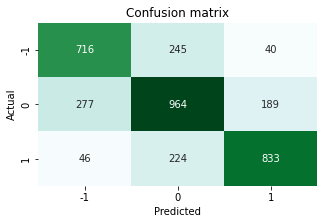

In [130]:
pipe = roBERTa_RF_Pipe


trainPipelineMlFlow(
                    mlf_XP="DSA_Tweets",
                    xp_name_iter="roBERTa - LR", 
                    pipeline = pipe, 
                    X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs':-1,'random_state':42})
                    )

### Transformation des données par roBERTa

In [133]:
import gc

gc.collect()

torch.cuda.empty_cache()


In [41]:
import torch
torch.cuda.empty_cache()

In [42]:
X_train_roBERTa = roBERTa_pipe.transform(X_train)

In [43]:
X_train_roBERTa

,roBERTa_neg,roBERTa_neu,roBERTa_pos
0,0.064939,0.808318,0.126744
1,0.918158,0.066100,0.015742
2,0.924613,0.070741,0.004646
3,0.783082,0.192980,0.023938
4,0.564197,0.404574,0.031229
...,...,...,...
27475,0.434403,0.445122,0.120474
27476,0.139542,0.635024,0.225433
27477,0.003337,0.022629,0.974034
27478,0.053331,0.357756,0.588913


In [44]:
X_test_roBERTa = roBERTa_pipe.transform(X_test)

In [72]:
X_train_roBERTa.to_parquet('/mnt/data/interim/X_train_roBERTa.gzip',compression='gzip')
X_test_roBERTa.to_parquet('/mnt/data/interim/X_test_roBERTa.gzip',compression='gzip')


In [45]:
roBERTa_RF = Pipeline(
    steps=[
        ("classifier", RandomForestClassifier(n_jobs=-1))
    ]
)


XP : roBERTa - RF - opti - 30 

pipeline : 
 subset            train    test
metric                         
f1_macro         0.7606  0.7444
precision_macro  0.7626  0.7451
recall_macro     0.7592  0.7446 

params: 
 

Confusion matrix: 

elapsed time : 0:02:09.753660


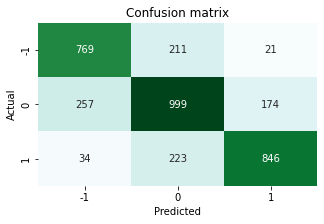

In [57]:
pipe = roBERTa_RF

params = target_params(pipe, {
    "bootstrap": [True, False],
    "class_weight": ["balanced", None],
    "n_estimators": [100, 300, 500, 800, 1200],
    "max_depth": [5, 8, 15, 25, 30],
    "min_samples_split": [2, 5, 10, 15, 100],
    "min_samples_leaf": [1, 2, 5, 10]
})


roBERTa_RF_=trainPipelineMlFlow(
                    mlf_XP="DSA_Tweets",
                    xp_name_iter="roBERTa - RF - opti - 30", 
                    pipeline = pipe, 
                    X_train = X_train_roBERTa, y_train = y_train, X_test = X_test_roBERTa, y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs':-1,'random_state':42}),
                    use_opti = True,
                    iterable_params=params,
                    n_iter=30
                    )

### roBERTa + xgBoost

https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

### Essai combinaison de différentes méthodes

In [48]:
class Blob(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[['polarity', 'subjectivity']] =  X[self.field].apply(lambda x:TextBlob(x).sentiment).apply(pd.Series)
        return X[['polarity', 'subjectivity']]

In [49]:
blob_pipe=Pipeline([
                     ('blob', Blob(field='text'))
                    ])

In [50]:
X_train_Blob=blob_pipe.transform(X_train)
X_train_Blob.head()

,polarity,subjectivity
0,0.000000,0.0
1,-0.976562,1.0
2,0.000000,0.0
3,0.000000,0.0
4,0.000000,0.0


In [51]:
X_test_Blob=blob_pipe.transform(X_test)
X_test_Blob.head()

,polarity,subjectivity
0,0.0000,0.066667
1,0.1625,0.800000
2,0.0000,0.500000
3,1.0000,1.000000
4,0.0000,0.000000


In [73]:
X_train_Blob.to_parquet('/mnt/data/interim/X_train_Blob.gzip',compression='gzip')
X_test_Blob.to_parquet('/mnt/data/interim/X_test_Blob.gzip',compression='gzip')

In [52]:
class Vader(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
        sid = SentimentIntensityAnalyzer()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        sid = SentimentIntensityAnalyzer()
        X[['neg', 'neu', 'pos', 'compound']] =  X[self.field].apply(sid.polarity_scores).apply(pd.Series)
        return X[['neg', 'neu', 'pos', 'compound']]

In [53]:
vader_pipe=Pipeline([
                     ('vader', Vader(field='text'))
                    ])

In [54]:
X_train_Vader=vader_pipe.transform(X_train)
X_train_Vader.head()

,neg,neu,pos,compound
0,0.000,1.000,0.0,0.0000
1,0.474,0.526,0.0,-0.7437
2,0.494,0.506,0.0,-0.5994
3,0.538,0.462,0.0,-0.3595
4,0.000,1.000,0.0,0.0000


In [55]:
X_test_Vader=vader_pipe.transform(X_test)
X_test_Vader.head()

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.000,0.670,0.330,0.7501
2,0.382,0.618,0.000,-0.7345
3,0.000,0.200,0.800,0.6114
4,0.000,0.393,0.607,0.4738


In [74]:
X_train_Vader.to_parquet('/mnt/data/interim/X_train_Vader.gzip',compression='gzip')
X_test_Vader.to_parquet('/mnt/data/interim/X_test_Vader.gzip',compression='gzip')

In [56]:
X_train_compound = pd.concat([X_train_roBERTa, X_train_Blob, X_train_Vader], axis=1)
X_test_compound = pd.concat([X_test_roBERTa, X_test_Blob, X_test_Vader], axis=1)


In [57]:
X_train_compound.head()

,roBERTa_neg,roBERTa_neu,roBERTa_pos,polarity,subjectivity,neg,neu,pos,compound
0,0.064939,0.808318,0.126744,0.000000,0.0,0.000,1.000,0.0,0.0000
1,0.918158,0.066100,0.015742,-0.976562,1.0,0.474,0.526,0.0,-0.7437
2,0.924613,0.070741,0.004646,0.000000,0.0,0.494,0.506,0.0,-0.5994
3,0.783082,0.192980,0.023938,0.000000,0.0,0.538,0.462,0.0,-0.3595
4,0.564197,0.404574,0.031229,0.000000,0.0,0.000,1.000,0.0,0.0000


In [58]:
X_test_compound.head()

,roBERTa_neg,roBERTa_neu,roBERTa_pos,polarity,subjectivity,neg,neu,pos,compound
0,0.034001,0.882237,0.083762,0.0000,0.066667,0.000,1.000,0.000,0.0000
1,0.001176,0.013178,0.985646,0.1625,0.800000,0.000,0.670,0.330,0.7501
2,0.908455,0.084444,0.007101,0.0000,0.500000,0.382,0.618,0.000,-0.7345
3,0.002410,0.013607,0.983983,1.0000,1.000000,0.000,0.200,0.800,0.6114
4,0.003367,0.030119,0.966514,0.0000,0.000000,0.000,0.393,0.607,0.4738


XP : roBERTa_Blob_Vader - RF - opti - 30 

pipeline : 
 subset            train    test
metric                         
f1_macro         0.8065  0.7564
precision_macro  0.8100  0.7591
recall_macro     0.8037  0.7544 

params: 
 

Confusion matrix: 

elapsed time : 0:03:21.937315


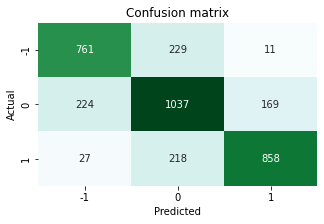

In [105]:
pipe = roBERTa_RF

params = target_params(pipe, {
    "bootstrap": [True, False],
    "class_weight": ["balanced", None],
    "n_estimators": [100, 300, 500, 800, 1200],
    "max_depth": [5, 8, 15, 25, 30],
    "min_samples_split": [2, 5, 10, 15, 100],
    "min_samples_leaf": [1, 2, 5, 10]
})


roBERTa_RF_=trainPipelineMlFlow(
                    mlf_XP="DSA_Tweets",
                    xp_name_iter="roBERTa_Blob_Vader - RF - opti - 30", 
                    pipeline = pipe, 
                    X_train = X_train_compound, y_train = y_train, X_test = X_test_compound, y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs':-1,'random_state':42}),
                    use_opti = True,
                    iterable_params=params,
                    n_iter=30
                    )

In [70]:
import xgboost as xgb

In [69]:
roBERTa_xgb = Pipeline(
    steps=[
        ("classifier", xgb.XGBClassifier())
    ]
)

[17:18:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XP : roBERTa - xgb - opti 

pipeline : 
 subset            train    test
metric                         
f1_macro         0.8116  0.7692
precision_macro  0.8137  0.7699
recall_macro     0.8099  0.7689 

params: 
 

Confusion matrix: 

elapsed time : 3:30:41.653581


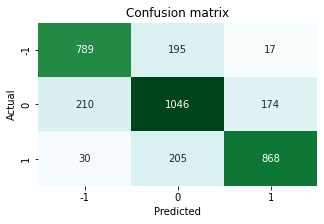

In [60]:
pipe = roBERTa_xgb

params = target_params(pipe, {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     })


roBERTa_xgb_ = trainPipelineMlFlow(
                    mlf_XP="DSA_Tweets",
                    xp_name_iter="roBERTa - xgb - opti", 
                    pipeline = pipe, 
                    X_train = X_train_compound, y_train = y_train, X_test = X_test_compound, y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs':-1,'random_state':42}),
                    use_opti = True,
                    iterable_params=params,
                    n_iter=20
                    )

### Essai opti F1

INFO: 'opti F1' does not exist. Creating a new experiment
XP : test 

pipeline : 
 subset            train    test
metric                         
f1_macro         0.9991  0.6890
precision_macro  0.9991  0.7190
recall_macro     0.9991  0.6779 

params: 
 

Confusion matrix: 

elapsed time : 0:00:04.605102


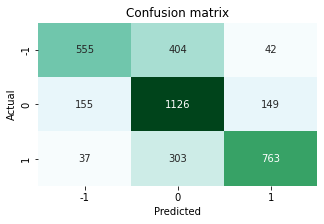

In [31]:
pipe = bow_pipeline


essai_=trainPipelineMlFlow(
                    mlf_XP="opti F1",
                    xp_name_iter="test", 
                    pipeline = pipe, 
                    X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test,
                    target_col = 'sentiment',
                    fixed_params = target_params(pipe, {'n_jobs':-1,'random_state':42}),
                    use_opti = False
                    )

In [32]:
essai_.predict_proba(X_train)

array([[0.02, 0.96, 0.02],
       [0.87, 0.11, 0.02],
       [0.91, 0.08, 0.01],
       ...,
       [0.03, 0.06, 0.91],
       [0.05, 0.14, 0.81],
       [0.02, 0.84, 0.14]])

In [33]:
X_train.head()

,text
0,"I`d have responded, if I were going"
1,Sooo SAD I will miss you here in San Diego!!!
2,my boss is bullying me...
3,what interview! leave me alone
4,"Sons of ****, why couldn`t they put them on t..."


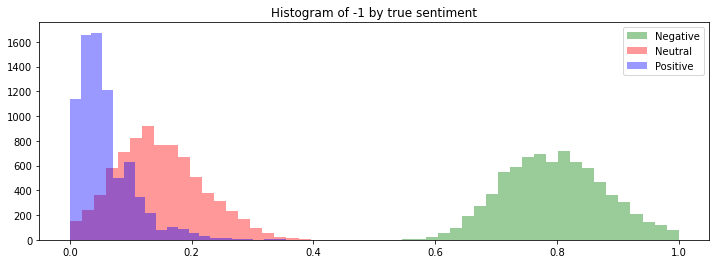

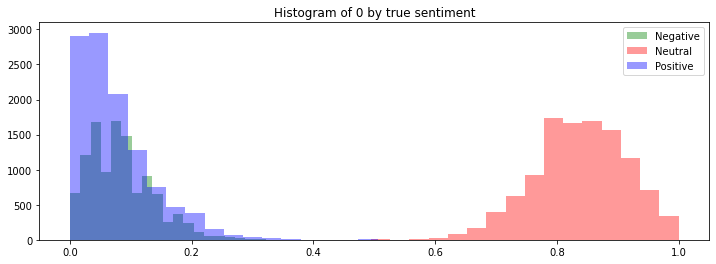

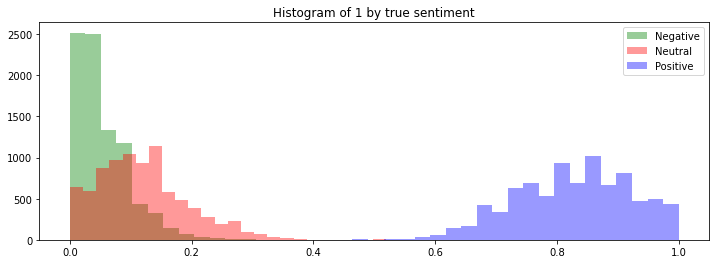

In [52]:
for var in [-1, 0, 1]:
    plt.figure(figsize=(12,4))
    sns.distplot(essai_.predict_proba(X_train)[(y_train['sentiment']==var),0], bins=30, kde=False, 
                 color='green', label='Negative')
    sns.distplot(essai_.predict_proba(X_train)[(y_train['sentiment']==var),1], bins=30, kde=False, 
                 color='red', label='Neutral')
    sns.distplot(essai_.predict_proba(X_train)[(y_train['sentiment']==var),2], bins=30, kde=False, 
                 color='blue', label='Positive')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment');

Stratégie : on maximise le seuil pour la décision positive, puis sur les non positifs, on maximise le seuil pour les négatifs, le reste est neutre

In [65]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [62]:
def find_optimal_f1_thresholds(pipe, X, y):
    
    probs = pipe.predict_proba(X)
    
    # keep probabilities for the positive outcome only
    pos_probs = probs[:,2]
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [f1_score([(1 if i==1 else 0) for i in y ], to_labels(pos_probs, t)) for t in thresholds]
    # get best threshold
    ix = np.argmax(scores)

    
    res = {'pos_threshold' : thresholds[ix], 'pos_f1' : scores[ix] }
    
    # keep probabilities for the positive outcome only
    neg_probs = probs[:,0]
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [f1_score([(1 if i==-1 else 0) for i in y ], to_labels(neg_probs, t)) for t in thresholds]
    # get best threshold
    ix = np.argmax(scores)

    
    res.update({'neg_threshold' : thresholds[ix], 'neg_f1' : scores[ix] })
    
    return res
    

In [119]:
thres = find_optimal_f1_thresholds(roBERTa_RF_, X_train_compound, y_train['sentiment'])

In [120]:
thres

{'pos_threshold': 0.392,
 'pos_f1': 0.8337924701561066,
 'neg_threshold': 0.423,
 'neg_f1': 0.8066423449490502}

In [109]:
y_train['sentiment']

0        0
1       -1
2       -1
3       -1
4       -1
        ..
27475   -1
27476   -1
27477    1
27478    1
27479    0
Name: sentiment, Length: 27480, dtype: int64

In [110]:
roBERTa_RF_.predict_proba(X_train_compound)

array([[0.014984  , 0.9562709 , 0.02874509],
       [0.93819736, 0.05573562, 0.00606702],
       [0.9380295 , 0.05034958, 0.01162092],
       ...,
       [0.00301866, 0.08883453, 0.90814681],
       [0.10620177, 0.4432684 , 0.45052983],
       [0.01658131, 0.36426037, 0.61915832]])

In [63]:
def sentiment_predict(pipe, X, dict_thres):
    seuil_pos=dict_thres['pos_threshold']
    seuil_neg=dict_thres['neg_threshold']

    probs = pipe.predict_proba(X)

    y_test_pred_pos = to_labels(probs[:,2], seuil_pos)
    y_test_pred_neg = to_labels(probs[:,0], seuil_neg)

    y_test_pred = y_test_pred_pos
    y_test_pred[(y_test_pred_pos==0)] = -y_test_pred_neg[(y_test_pred_pos==0)]
    return y_test_pred

In [122]:
y_test_pred = sentiment_predict(roBERTa_RF_, X_test_compound,thres)

In [123]:
f1_score(y_test, y_test_pred, average='macro')

0.7582696304640235

In [66]:
thres_xgb = find_optimal_f1_thresholds(roBERTa_xgb_, X_train_compound, y_train['sentiment'])

In [67]:
y_test_pred_xgb = sentiment_predict(roBERTa_xgb_, X_test_compound,thres_xgb)

In [68]:
f1_score(y_test, y_test_pred_xgb, average='macro')

0.7589563821278196

# SHAP

In [76]:
import shap

shap.initjs()


# sujets

In [ ]:
import gensim.corpora as corpora# Create Dictionary
id2word = corpora.Dictionary(data_words)